# Load data

In [1]:
from pathlib import Path
import pickle
import numpy as np
import matplotlib.pyplot as plt

feat_dir = "./features"
models_dir = "./models"

load_file = f"{feat_dir}/new_X_train.pkl"
with open(load_file, "rb") as load_file:
    X_train = pickle.load(load_file)
    
load_file = f"{feat_dir}/new_y_train.pkl"
with open(load_file, "rb") as load_file:
    y_train = pickle.load(load_file)
    
load_file = f"{feat_dir}/new_X_eval.pkl"
with open(load_file, "rb") as load_file:
    X_eval = pickle.load(load_file)
    
load_file = f"{feat_dir}/new_y_eval.pkl"
with open(load_file, "rb") as load_file:
    y_eval = pickle.load(load_file)
    
load_file = f"{feat_dir}/new_X_unbal.pkl"
with open(load_file, "rb") as load_file:
    X_unbal = pickle.load(load_file)
    
load_file = f"{feat_dir}/new_y_unbal.pkl"
with open(load_file, "rb") as load_file:
    y_unbal = pickle.load(load_file)

   ## Load labels

In [2]:
load_file = f"{feat_dir}/new_multiLabelBinarizer.pkl"
with open(load_file, "rb") as load_file:
    mlb = pickle.load(load_file)
    
#Load classes names
with open(f"{feat_dir}/new_classes_dict.pkl", "rb") as classes_file:
    classes_dict = pickle.load(classes_file)

# Create model

In [4]:
import keras
from keras import callbacks
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Activation, Lambda
import keras.backend as K
import tensorflow as tf


def attention_pooling(inputs, **kwargs):
    [out, att] = inputs

    epsilon = 1e-7
    att = K.clip(att, epsilon, 1. - epsilon)
    normalized_att = att / K.sum(att, axis=1)[:, None, :]

    return K.sum(out * normalized_att, axis=1)

def pooling_shape(input_shape):

    if isinstance(input_shape, list):
        (sample_num, time_steps, freq_bins) = input_shape[0]

    else:
        (sample_num, time_steps, freq_bins) = input_shape

    return (sample_num, freq_bins)

time_steps = 10
freq_bins = 128
classes_num = 10

# Hyper parameters
hidden_units = 1024
drop_rate = 0.5
batch_size = 500

# Embedded layers
input_layer = Input(shape=X_train[0].shape)

a1 = Dense(hidden_units)(input_layer)
a1 = BatchNormalization()(a1)
a1 = Activation('relu')(a1)
a1 = Dropout(drop_rate)(a1)

a2 = Dense(hidden_units)(a1)
a2 = BatchNormalization()(a2)
a2 = Activation('relu')(a2)
a2 = Dropout(drop_rate)(a2)

a3 = Dense(hidden_units)(a2)
a3 = BatchNormalization()(a3)
a3 = Activation('relu')(a3)
a3 = Dropout(drop_rate)(a3)
cla = Dense(hidden_units, activation='linear')(a3)
att = Dense(hidden_units, activation='sigmoid')(a3)

b1 = Lambda(attention_pooling, output_shape=pooling_shape)([cla, att])
b1 = BatchNormalization()(b1)
b1 = Activation(activation='relu')(b1)
b1 = Dropout(drop_rate)(b1)

output_layer = Dense(classes_num, activation='sigmoid')(b1)

model = keras.Model(inputs=input_layer, outputs=output_layer, name="qiuqiangkong")
model.compile(loss='binary_crossentropy', optimizer="Adam", metrics=["accuracy"])
model.summary()

Model: "qiuqiangkong"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 128)]    0           []                               
                                                                                                  
 dense (Dense)                  (None, 10, 1024)     132096      ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 10, 1024)    4096        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 10, 1024)     0           ['batch_normalization[

## Train the model only with balanced data

In [5]:
model.load_weights(f"{models_dir}/new_qiuqiangkong_b64_bal.tf")

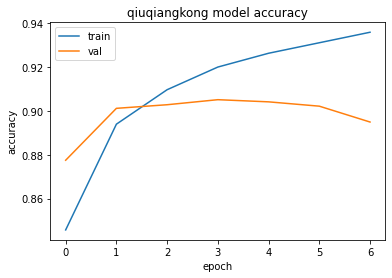

In [8]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('qiuqiangkong model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

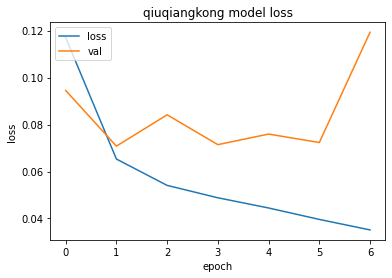

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('qiuqiangkong model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val'], loc='upper left')
plt.show()

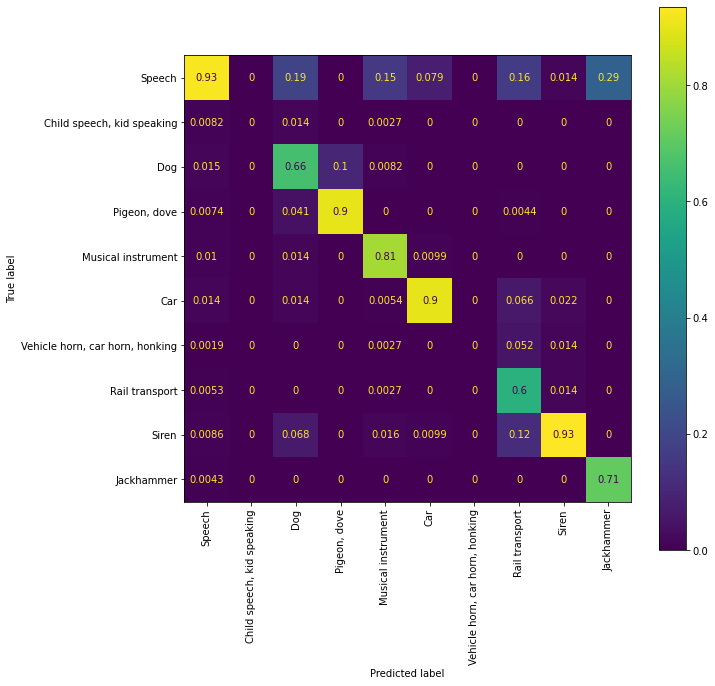

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
y_pred = model.predict(X_eval)

# Transform one hot encoding to a series of ints for confusion matrix
y_pred = np.argmax(y_pred, axis=1)
y_eval_transformed = np.argmax(y_eval, axis=1)

fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay.from_predictions(y_eval_transformed, y_pred, normalize="pred",
                                              display_labels=[classes_dict.get(y) for y in mlb.classes_],
                                               xticks_rotation='vertical', ax=ax)

## Training with balanced and unbalanced data

In [10]:
X = np.concatenate((X_train, X_unbal))
y = np.concatenate((y_train, y_unbal))

model.save_weights(f"{models_dir}/new_qiuqiangkong_b128_all.tf")

In [11]:
model.load_weights(f"{models_dir}/new_qiuqiangkong_b128_all.tf")

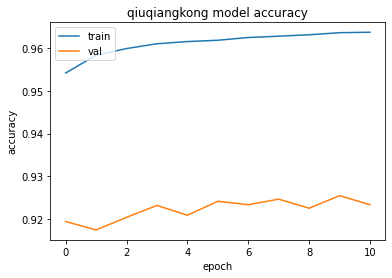

In [19]:
import matplotlib.pyplot as plt

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('qiuqiangkong model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

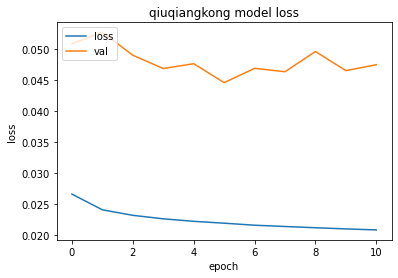

In [20]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('qiuqiangkong model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val'], loc='upper left')
plt.show()

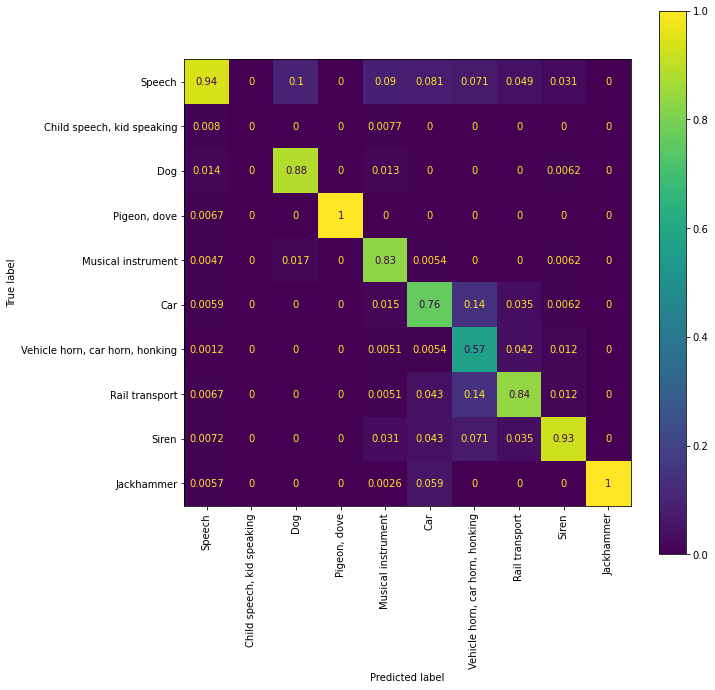

In [12]:
# Generate predictions
y_pred = model.predict(X_eval)

# Transform one hot encoding to a series of ints for confusion matrix
y_pred = np.argmax(y_pred, axis=1)
y_eval_transformed = np.argmax(y_eval, axis=1)

fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay.from_predictions(y_eval_transformed, y_pred,
                                              display_labels=[classes_dict.get(y) for y in mlb.classes_],
                                               normalize="pred", xticks_rotation='vertical', ax=ax)

## Trying to improve with data augmentation
Instead of using all the unbalanced videos, we'll select all except speech

In [19]:
df = pd.DataFrame(y_unbal)
df.sum(numeric_only=True, axis=0)

0    950898
1      1722
2      6861
3      5561
4    102343
5     27210
6      1982
7      7597
8      7285
9       118
dtype: int64

We're going to drop columns 0, 4 and 5 (Speech, musical instrument and car) to make the set more balanced

In [38]:
df_sel = df[(df[0] != 1) & (df[4] != 1) & (df[5] != 1)]
df_sel.sum(numeric_only=True, axis=0)

0       0
1    1722
2    6861
3    5561
4       0
5       0
6    1982
7    7597
8    7285
9     118
dtype: int64

In [47]:
filter_rows = list(df_sel.index)

y_unbal = y_unbal[filter_rows]
X_unbal = X_unbal[filter_rows]

In [52]:
X = np.concatenate((X_train, X_unbal))
y = np.concatenate((y_train, y_unbal))

In [63]:
res = pd.DataFrame(y).sum(numeric_only=True, axis=0)

In [65]:
res

0    5303
1    1757
2    7041
3    5621
4     444
5     197
6    2011
7    7784
8    7491
9     160
dtype: int64

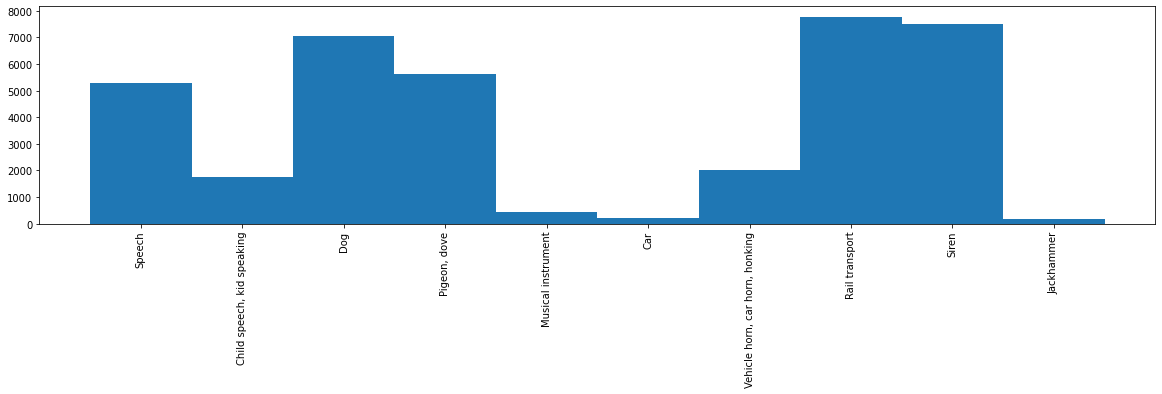

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))    
plt.bar(classes_dict.values(), res, 1)
plt.xticks(rotation = 90)
plt.show()

In [66]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)


history3 = model.fit(
    X,
    y,
    batch_size=64, # batch size 1 doesn't work
    epochs=100,
    validation_data=(X_eval, y_eval),
    callbacks =[earlystopping]
)

Epoch 1/100
591/591 [==============================] - 52s 83ms/step - loss: 0.0978 - accuracy: 0.8290 - val_loss: 0.0965 - val_accuracy: 0.8064
Epoch 2/100
591/591 [==============================] - 105s 178ms/step - loss: 0.0791 - accuracy: 0.8502 - val_loss: 0.0922 - val_accuracy: 0.8254
Epoch 3/100
591/591 [==============================] - 101s 170ms/step - loss: 0.0752 - accuracy: 0.8582 - val_loss: 0.0918 - val_accuracy: 0.8243
Epoch 4/100
591/591 [==============================] - 96s 163ms/step - loss: 0.0735 - accuracy: 0.8626 - val_loss: 0.0874 - val_accuracy: 0.8376
Epoch 5/100
591/591 [==============================] - 93s 158ms/step - loss: 0.0710 - accuracy: 0.8677 - val_loss: 0.0939 - val_accuracy: 0.8195
Epoch 6/100
591/591 [==============================] - 114s 192ms/step - loss: 0.0692 - accuracy: 0.8697 - val_loss: 0.0895 - val_accuracy: 0.8262
Epoch 7/100
591/591 [==============================] - 121s 205ms/step - loss: 0.0675 - accuracy: 0.8733 - val_loss: 0.112

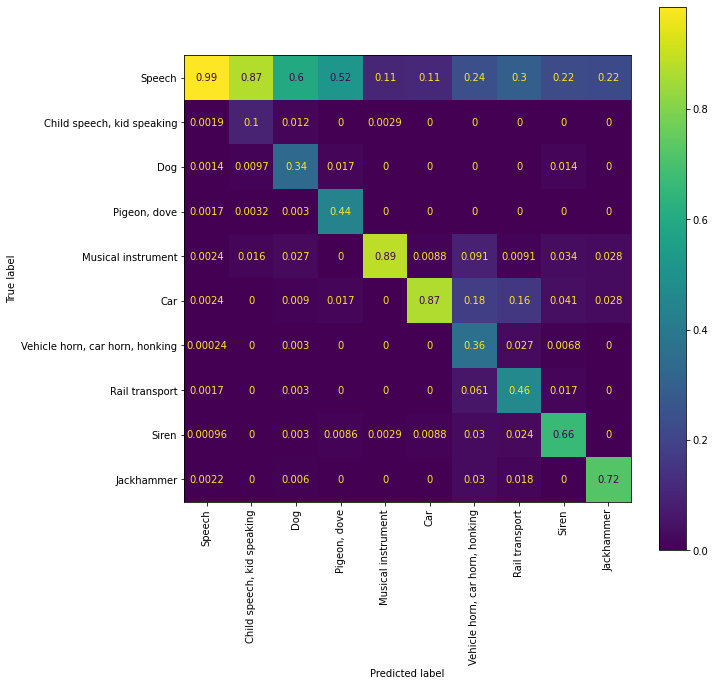

In [67]:
# Generate predictions
y_pred = model.predict(X_eval)

# Transform one hot encoding to a series of ints for confusion matrix
y_pred = np.argmax(y_pred, axis=1)
y_eval_transformed = np.argmax(y_eval, axis=1)

fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay.from_predictions(y_eval_transformed, y_pred,
                                              display_labels=[classes_dict.get(y) for y in mlb.classes_],
                                               normalize="pred", xticks_rotation='vertical', ax=ax)

This approach is worse than the previous